In [245]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import glob
import math
import gc
from tqdm import tqdm

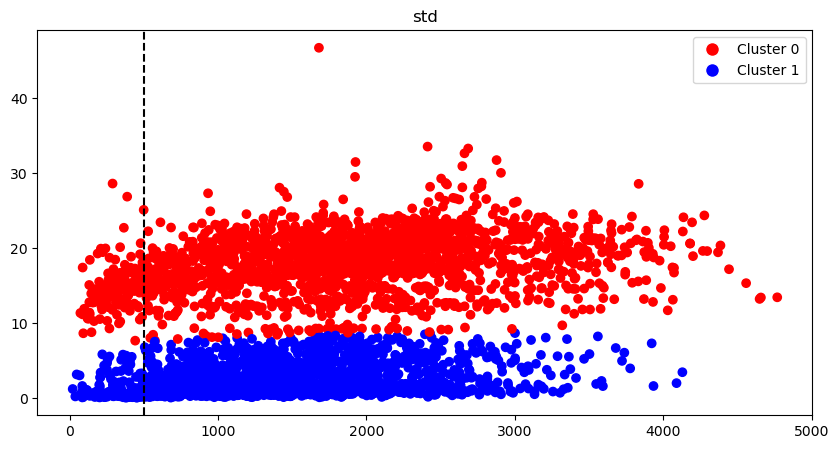

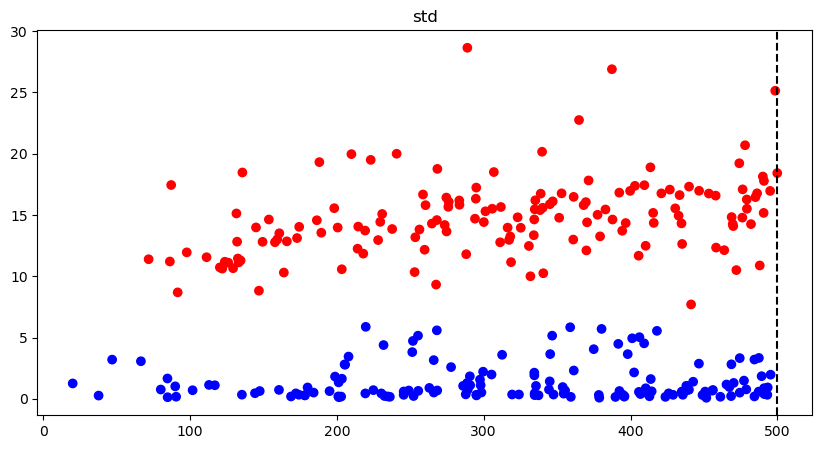

In [246]:
# WHich metric are we looking at?
metric= 'std'
limit = 500

# Loading dataframe. Meidan had the cleanest clustering
df = pd.read_feather(f'outputs/data_{metric}.feather')

plt.figure(figsize=(10,5))
scatter = plt.scatter(x=df['x'], y=df['y'], c=df['cluster'], label=df['cluster'], cmap='bwr')
plt.axvline(limit, color='black', linestyle='--')
plt.title(metric)

# Get unique cluster labels and associated color indices
unique_labels, color_indices = np.unique(df['cluster'], return_inverse=True)

# Create legend entries based on cluster labels and associated colors
legend_handles = []
for label, color_index in zip(unique_labels, color_indices):
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(color_index), markersize=10, label=f'Cluster {label}'))

# Adding legend with custom handles
plt.legend(handles=legend_handles)

plt.show()

# What if I limit the analysis to under a distance limit?
df = df[df['x'] <= limit]

# Creating seperate dfs for each cluster
df0 = df[df['cluster']==0]
df1 = df[df['cluster']==1]

plt.figure(figsize=(10,5))
scatter = plt.scatter(x=df['x'], y=df['y'], c=df['cluster'], label=df['cluster'], cmap='bwr')
plt.axvline(limit, color='black', linestyle='--')
plt.title(metric)
plt.show()

In [247]:
# Counting which stations are in which cluster
value_counts00 = pd.DataFrame({'values0':df0['station_0'].value_counts()})
value_counts01 = pd.DataFrame({'values1':df0['station_1'].value_counts()})
value_counts10 = pd.DataFrame({'values0':df1['station_0'].value_counts()})
value_counts11 = pd.DataFrame({'values1':df1['station_1'].value_counts()})


# Combining the top sums into one sum per station for eadh cluster
value_counts0 = pd.concat([value_counts00, value_counts01], axis=1, join='outer', sort=True)
value_counts1 = pd.concat([value_counts10, value_counts11], axis=1, join='outer', sort=True)

if df0['y'].mean() > df1['y'].mean():
	value_counts0['upper'] = value_counts0.sum(axis=1)
	value_counts1['lower'] = value_counts1.sum(axis=1)

else:
	value_counts0['lower'] = value_counts0.sum(axis=1)
	value_counts1['upper'] = value_counts1.sum(axis=1)

value_counts0.drop(['values0', 'values1'], axis=1, inplace=True)
value_counts1.drop(['values0', 'values1'], axis=1, inplace=True)

In [248]:
# Merging the dataframes on the station label axis
value_counts = pd.concat([value_counts0, value_counts1], axis=1, join='outer', sort=True)
value_counts.fillna(0, inplace=True)

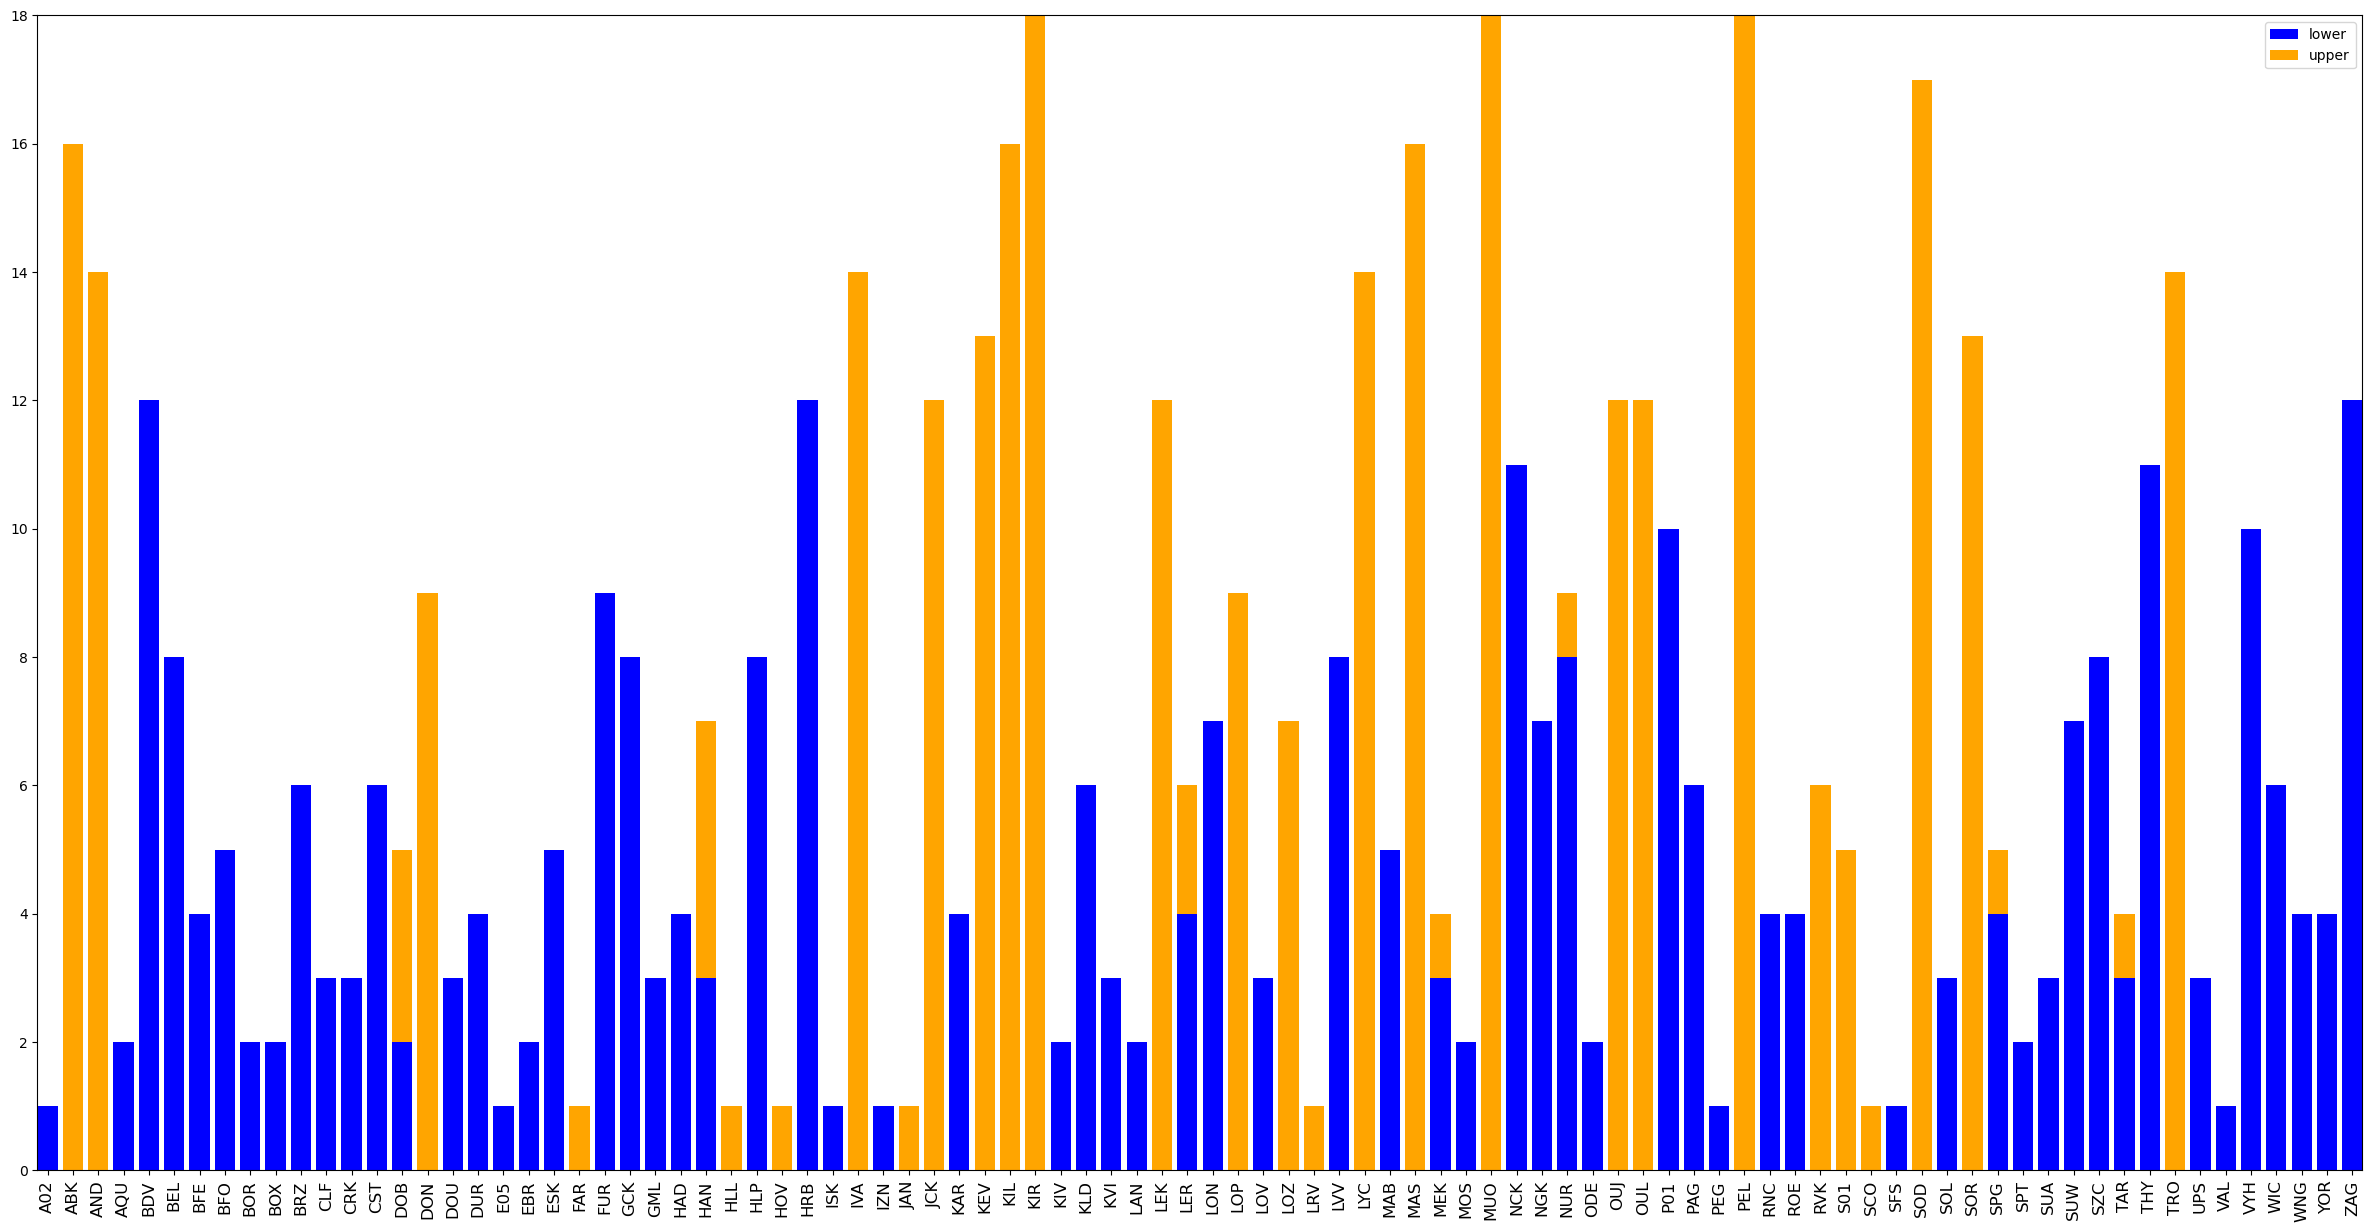

In [249]:
fig,ax = plt.subplots(figsize=(30,15))
ax.bar(value_counts.index, value_counts['lower'], color='blue', label='lower')
ax.bar(value_counts.index, value_counts['upper'], bottom=value_counts['lower'], color='orange', label='upper')
plt.margins(x=0, y=0)
plt.legend()
plt.xticks(fontsize=12, rotation=90)
plt.show()


In [250]:
# Calculating how often a station is in the upper cluster
percentage_in_upper = (value_counts['upper']/(value_counts['upper']+value_counts['lower']))*100
value_counts['perc_in_upper'] = percentage_in_upper

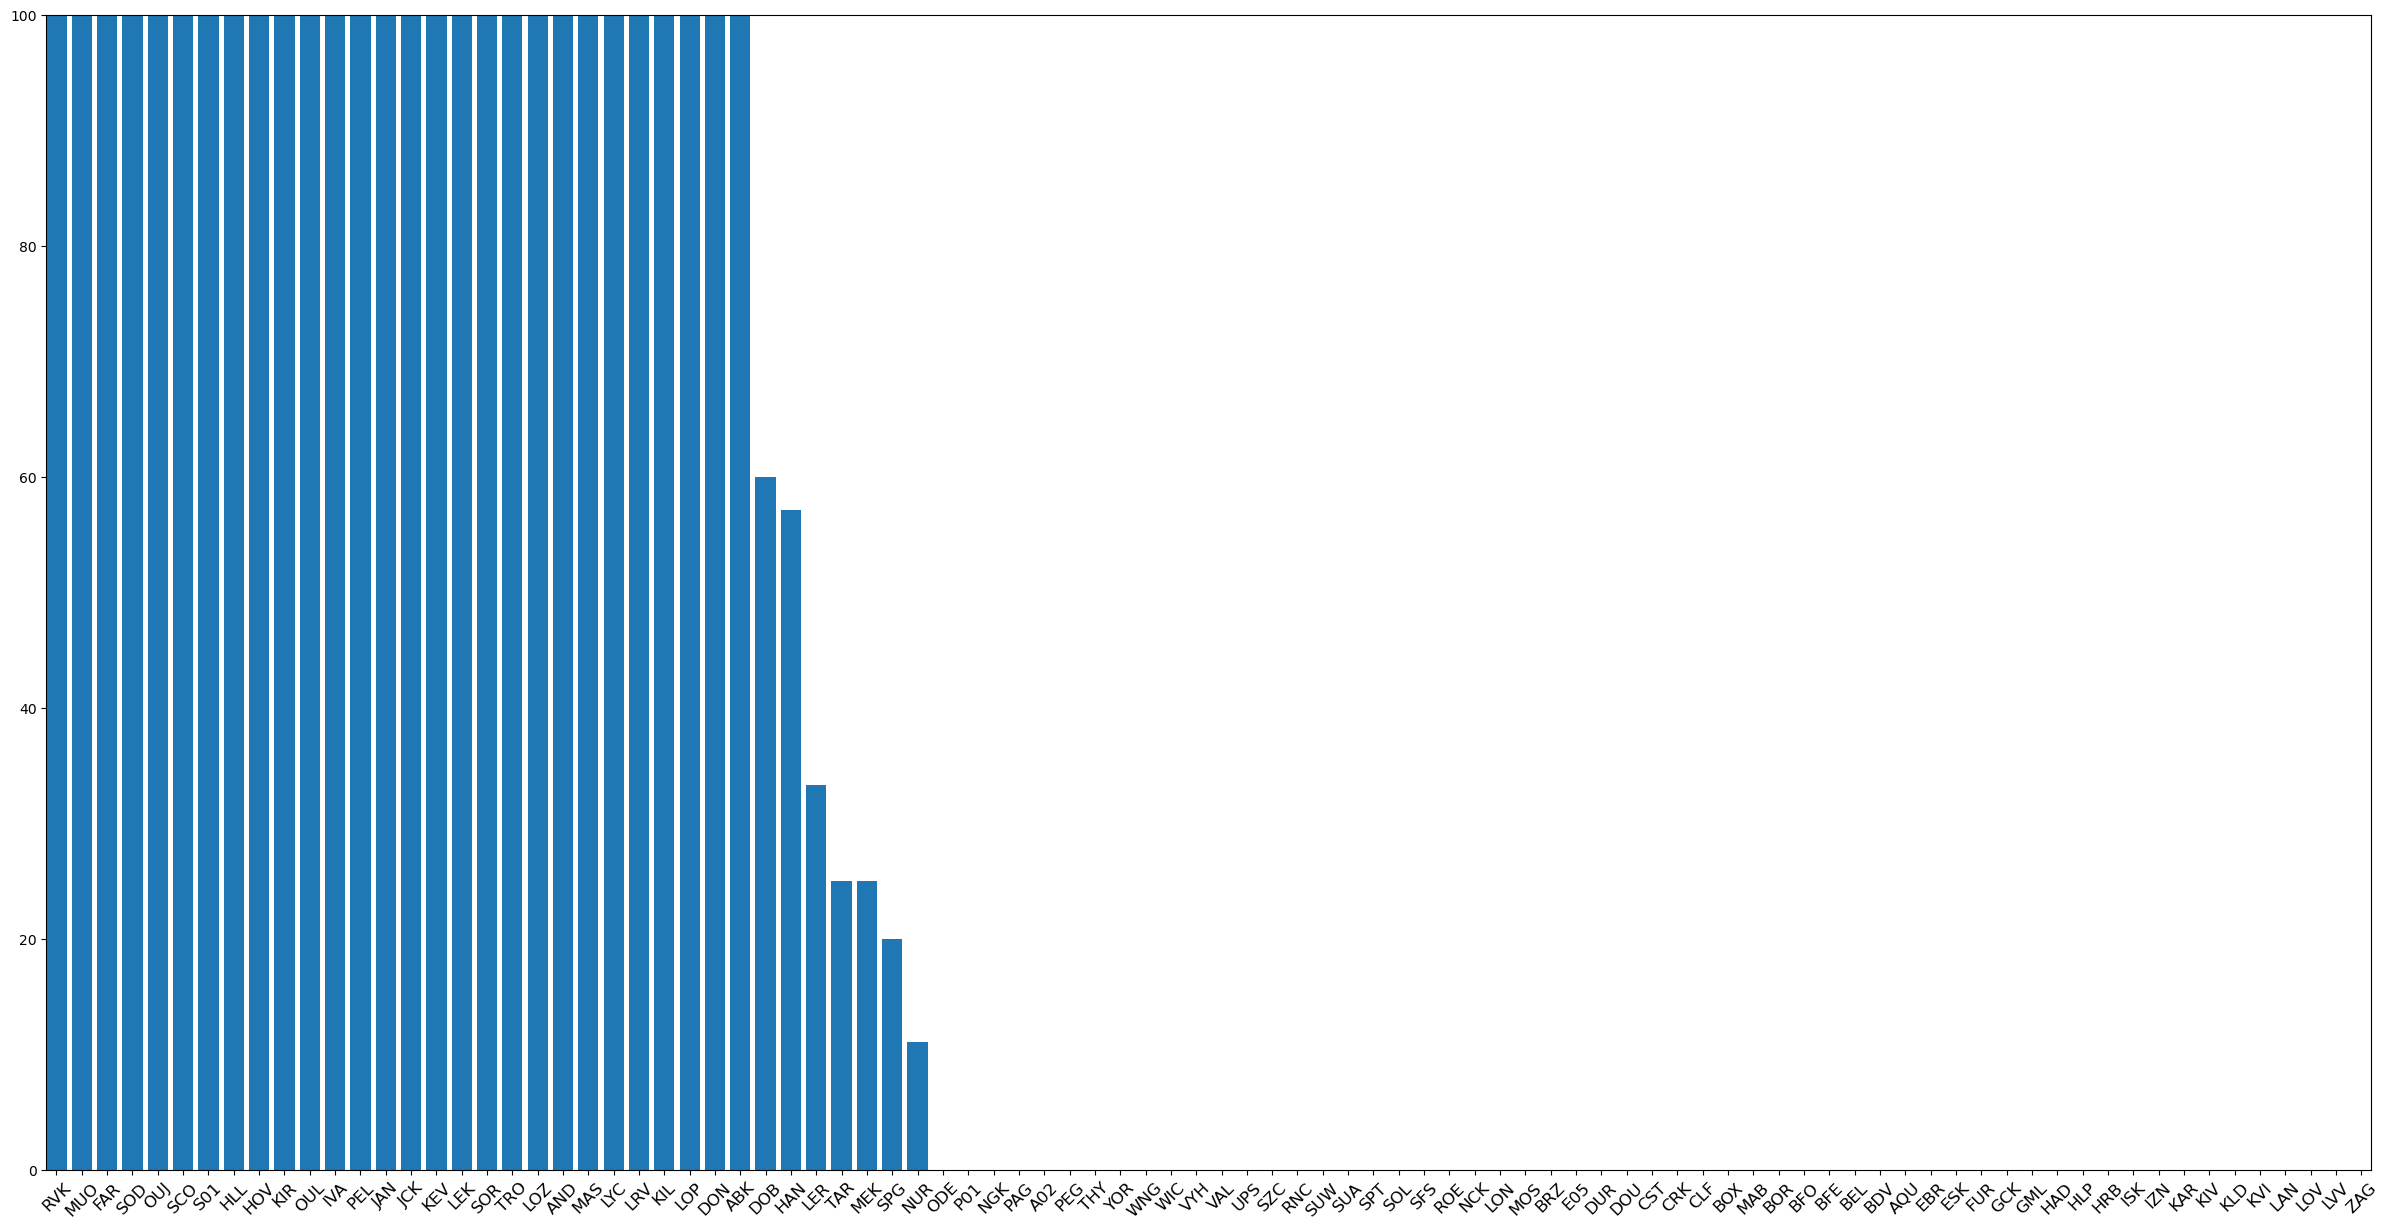

In [251]:
# Plotting the sataions based on percentage in teh upper cluster
sorted_df = value_counts.sort_values('perc_in_upper', ascending=False)
fig,ax = plt.subplots(figsize=(30,15))
ax.bar(sorted_df.index, sorted_df['perc_in_upper'])
plt.xticks(fontsize=12, rotation=45)
plt.margins(x=0, y=0)
plt.show()

In [252]:
# Segmenting the stations over 90% in the upper cluster
upper_stations = value_counts[value_counts['perc_in_upper']>=80]
mid_stations = value_counts[(value_counts['perc_in_upper']<80)&(value_counts['perc_in_upper']>=20)]
low_stations = value_counts[value_counts['perc_in_upper']<20]

upper_stations = upper_stations.reset_index(inplace=False, drop=False).rename(columns={'index':'station'})
mid_stations = mid_stations.reset_index(inplace=False, drop=False).rename(columns={'index':'station'})
low_stations = low_stations.reset_index(inplace=False, drop=False).rename(columns={'index':'station'})
value_counts = value_counts.reset_index(inplace=False, drop=False).rename(columns={'index':'station'})
print(value_counts)

   station  lower  upper  perc_in_upper
0      A02    1.0    0.0            0.0
1      ABK    0.0   16.0          100.0
2      AND    0.0   14.0          100.0
3      AQU    2.0    0.0            0.0
4      BDV   12.0    0.0            0.0
..     ...    ...    ...            ...
87     VYH   10.0    0.0            0.0
88     WIC    6.0    0.0            0.0
89     WNG    4.0    0.0            0.0
90     YOR    4.0    0.0            0.0
91     ZAG   12.0    0.0            0.0

[92 rows x 4 columns]


In [253]:
min_lat = 36
min_lon = 338
max_lat = 71
max_lon = 41

station_locations = pd.read_csv('supermag-stations-info.csv')

# fmt: off
stations_to_remove = ['A09', 'A10', 'A11', 'ALT', 'ARK', 'ASA', 'ASH', 'B01',
						'BJI', 'C09', 'CGO', 'CPL', 'CPY', 'CWE', 'DRB', 'E01',
						'E02', 'E03', 'E04', 'EUA', 'FTN', 'FVE', 'GLK', 'GRK',
						'KAU', 'KGD', 'KOR', 'KZN', 'LNN', 'M02', 'M11', 'MCE',
						'MHV', 'MNK', 'MSK', 'MZH', 'NAD', 'NKK', 'NR2', 'NVL',
						'PKS', 'PNL', 'POD', 'PRG', 'R01', 'R02', 'R03', 'R04',
						'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'RSV', 'SAH',
						'SAS', 'SKD', 'SMA', 'SUT', 'T26', 'T27', 'T60', 'T62',
						'TKT', 'TLK', 'TOL', 'TOR', 'TTB', 'TUL', 'W01', 'W02',
						'W03', 'W04', 'W05', 'WSE', 'WTK', 'YSS', 'KHS', 'BEY', 'KLI']
# fmt: on

station_locations = station_locations[
	station_locations['IAGA'].isin(stations_to_remove) == False
]

df = station_locations[
	(station_locations['GEOLAT'] >= min_lat)
	& (station_locations['GEOLAT'] <= max_lat)
	& (
		(station_locations['GEOLON'] >= min_lon)
		| (station_locations['GEOLON'] <= max_lon)
	)
]

df.reset_index(inplace=True, drop=True)

stations = df['IAGA'].tolist()
print(df.columns)

Index(['IAGA', 'GEOLON', 'GEOLAT', 'AACGMLON', 'AACGMLAT', 'STATION-NAME',
       'OPERATOR-NUM', 'OPERATORS'],
      dtype='object')


In [254]:
df = df[['IAGA','GEOLON', 'GEOLAT']]
df['GEOLON'] = (df['GEOLON'] + 180) % 360 - 180
df['upper_color'] = np.where(df['IAGA'].isin(upper_stations['station']), 'red', 'black')
df['mid_color'] = np.where(df['IAGA'].isin(mid_stations['station']), 'purple', 'black')
df['low_color'] = np.where(df['IAGA'].isin(low_stations['station']), 'green', 'black')
df['limit_color'] = np.where(df['IAGA'].isin(value_counts['station']), 'orange', 'black')

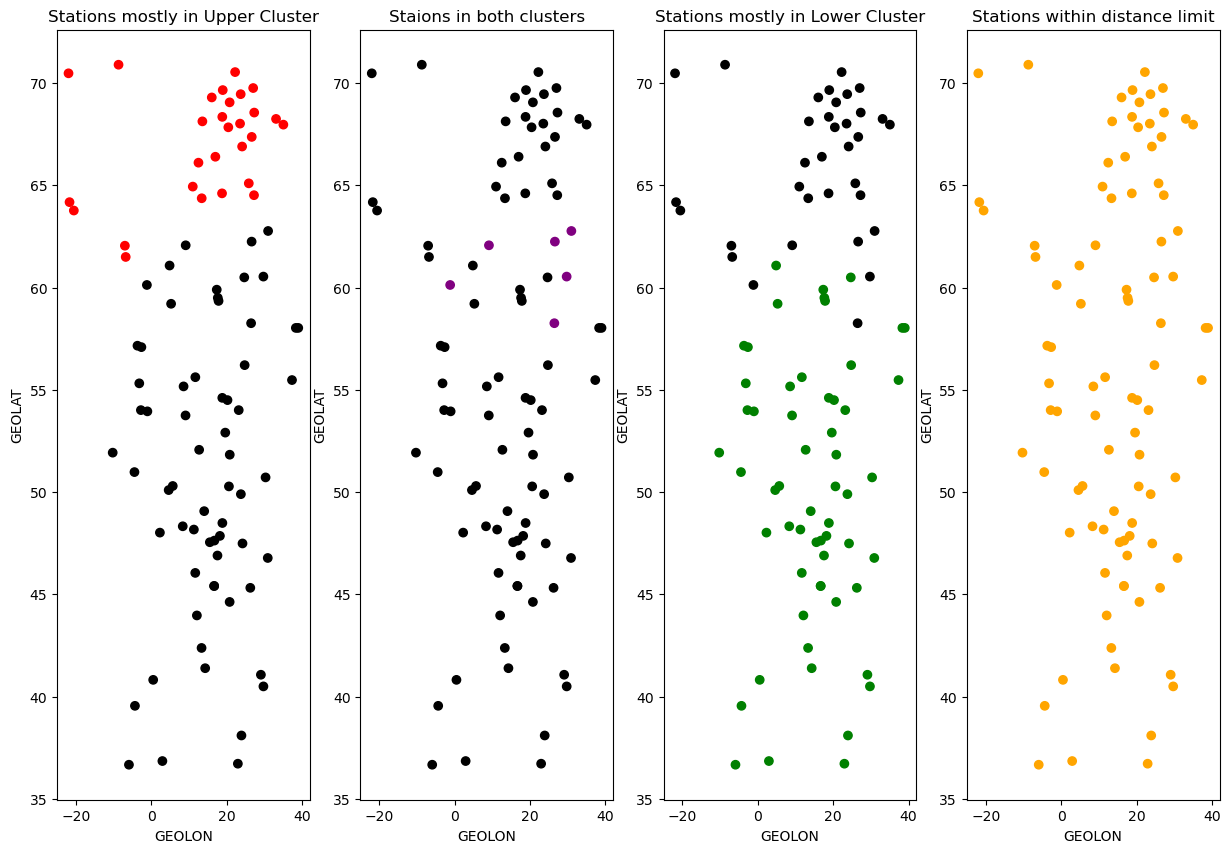

In [255]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(141)
plt.scatter(x=df['GEOLON'], y=df['GEOLAT'], c=df['upper_color'])
plt.margins(x=.05, y=.05)
plt.xlabel('GEOLON')
plt.ylabel('GEOLAT')
ax1.set_title('Stations mostly in Upper Cluster')

ax2 = plt.subplot(142)
plt.scatter(x=df['GEOLON'], y=df['GEOLAT'], c=df['mid_color'])
plt.margins(x=.05, y=.05)
plt.xlabel('GEOLON')
plt.ylabel('GEOLAT')
ax2.set_title('Staions in both clusters')

ax3 = plt.subplot(143)
plt.scatter(x=df['GEOLON'], y=df['GEOLAT'], c=df['low_color'])
plt.margins(x=.05, y=.05)
plt.xlabel('GEOLON')
plt.ylabel('GEOLAT')
ax3.set_title('Stations mostly in Lower Cluster')

ax4 = plt.subplot(144)
plt.scatter(x=df['GEOLON'], y=df['GEOLAT'], c=df['limit_color'])
plt.margins(x=.05, y=.05)
plt.xlabel('GEOLON')
plt.ylabel('GEOLAT')
ax4.set_title('Stations within distance limit')
plt.show()